In [224]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
pd.set_option('display.max_columns', 500) ## show more columns

# Analysis of Presidential22 dataset
This section is used to analyze the Presidential22 dataset

In [252]:
from datasets import load_presidential22, feature_engineering, remove_presidential22_extra_columns

dataset = load_presidential22(floor_nb_tweets=2)
#dataset = feature_engineering(dataset)
dataset.sample(n=3)

dataset = feature_engineering(dataset)
dataset_model = remove_presidential22_extra_columns(dataset)


In [261]:
def to_1D(series):
    return pd.Series([x['tag'] for _list in series for x in _list])

def plot_rules(data_to_plot):
    plt.figure(figsize=(4,2))
    data = to_1D(data_to_plot['matching_rules']).value_counts()
    data["Jean-Luc Mélenchon"] += data["Jean-Luc Melenchon"]
    data = data.drop(["Jean-Luc Melenchon"]).sort_values();
    data.plot(kind='barh')
    plt.title('Nombre de mention des règles par candidat')
    plt.show() 


<IPython.core.display.Javascript object>


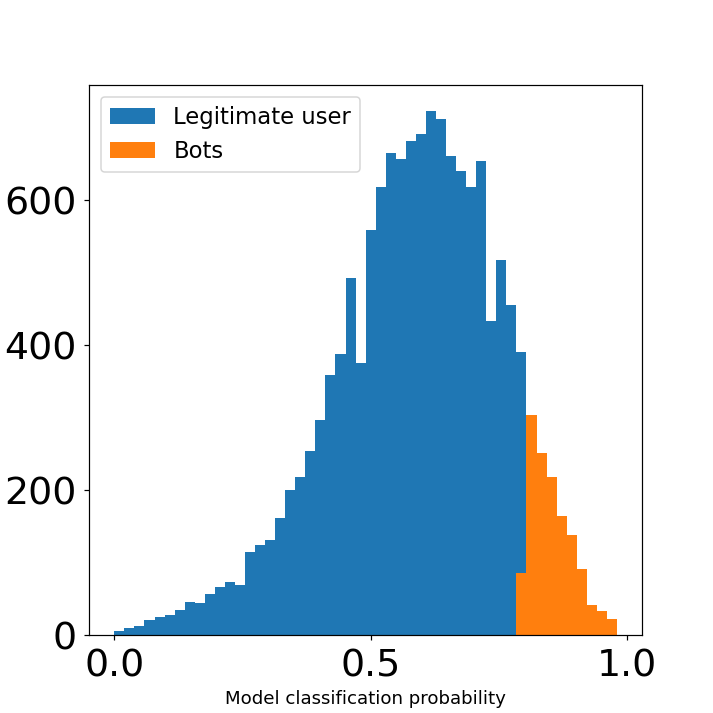

In [262]:
from sklearn.datasets import make_classification
import joblib

import matplotlib.pyplot as plt

clf = joblib.load('rf-model.pkl')
prediction = clf.predict_proba(dataset_model.select_dtypes(include=['int64', 'float64', 'bool']))
threshold = 0.8
bool_mask = prediction[:,1] > threshold
dataset['label'] = bool_mask
dataset['proba'] = prediction[:,1]

prediction=prediction[:,1]

plt.figure(figsize=(6,6))
_,bins,_ = plt.hist(prediction[prediction < 1], bins=50, label='Legitimate user')
plt.hist(prediction[prediction >= threshold], bins=bins, label='Bots')

plt.xlabel('Model classification probability', fontsize=12)
plt.ylabel('Number of records in each bucket', fontsize=12)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

<IPython.core.display.Javascript object>


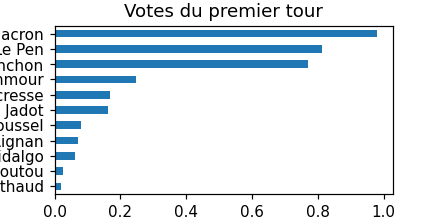

Text(0.5, 0, 'Nombre de votes')

In [263]:
plot_rules(dataset)
list_vote = [("Emmanuel Macron", 9783058), 
                      ("Eric Zemmour", 2485226),
                     ("Marine Le Pen", 8133828),
                     ("Jean-Luc Mélenchon", 7712520),
                     ("Valérie Pécresse", 1679001),
                     ("Philippe Poutou", 268904),
                     ("Anne Hidalgo", 616478),
                     ("Yannick Jadot", 1627853),
                     ("Nicolas Dupont-Aignan", 725176),
                     ("Nathalie Arthaud", 197094),
                     ("Fabien Roussel", 802422)]
idx = [x[0] for x in list_vote]
vals = [x[1] for x in list_vote]

pd.Series(vals, index=idx).sort_values().plot(kind='barh')
plt.title('Votes du premier tour')
plt.xlabel('Nombre de votes')

<IPython.core.display.Javascript object>


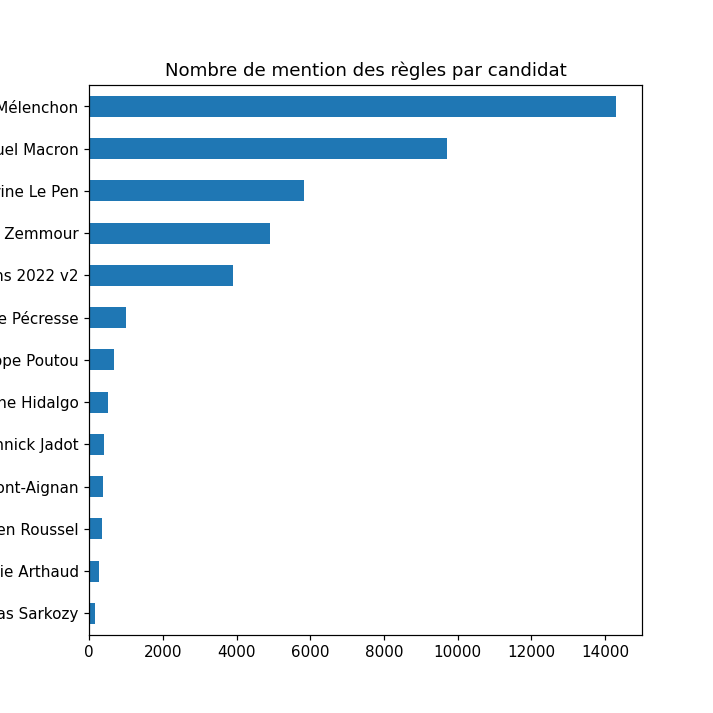

In [256]:
plot_rules(dataset[dataset['label'] == 0])

<IPython.core.display.Javascript object>


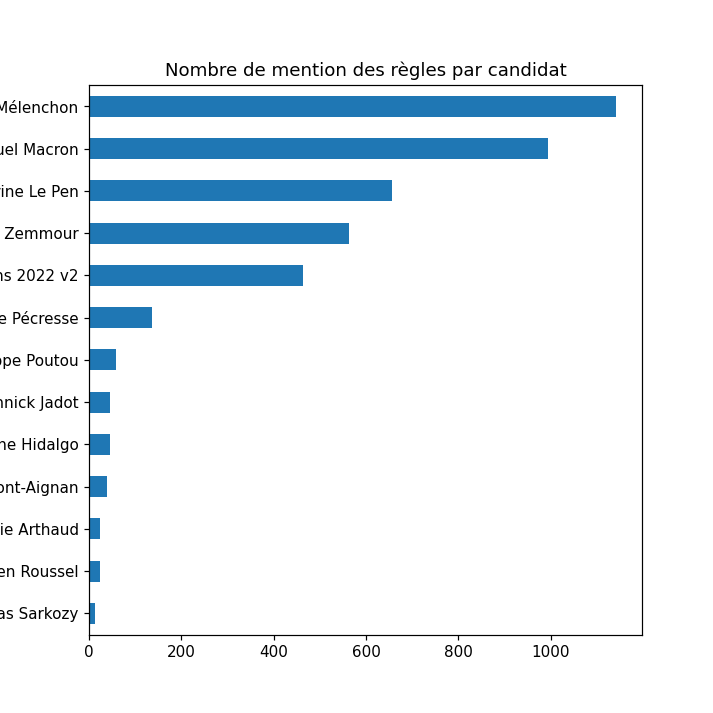

In [257]:
plot_rules(dataset[dataset['label'] == 1])

## Botometer vs datasets analysis

['damienjhn' 'MatthiasSchari1' 'Michiwendi22' 'MarPiot' 'Quetteville6'
 'clemfr741' 'ibrahimhooper' 'rigelafond' 'fredhand71' 'hvorforkrig'
 'lindagoodliffe' 'osugi41586060' 'Fiozope1' 'userjkk' 'ArthurGuerin8'
 'onikiaga' 'Lauractsx' 'FinancialBear' 'youssev212' 'emicetw'
 'PottiezSabine' 'DartNose' 'betti0864' 'philhmitchell54' '321jz'
 'Fiaksologie' 'SuzetteHervieu' 'DurandFred4' 'BluestUnicorn'
 'PopeyeLeMarin2' 'CharleyLucy2' 'mrssheeran08' 'Chris07479124'
 'Francedugeneral' 'thomas_dvl' 'TheRealBlancN' 'JRGLeCamus' 'DjgNicklas'
 'c_camandone' 'Ines11774393' 'Riki45477330' 'apaches__' 'G_u_i_l_e'
 'Made942' 'wil75' 'pasoupakos' 'Nogaruki' 'justelucide11' 'Paula_fer31'
 'serendipytear' 'yadayad26196545' 'FabienBougle' 'PaulReeceHam'
 'i_ismael_' 'Benbch16' 'GoldbaumMojzesz' 'by_elsaaa' 'Bougihotv'
 'AMINEALLEL' 'IdiotInutile' 'LeGrinchIsBack' 'fayyaz786pk' 'mowgly_nero'
 'CanariSo' 'Druci598__' 'DussolAlexis' 'tigerliIyjk' 'smallbrownring'
 'iwonawozniak3' 'XVIVLXX' 'AstreSauvage' 

<IPython.core.display.Javascript object>


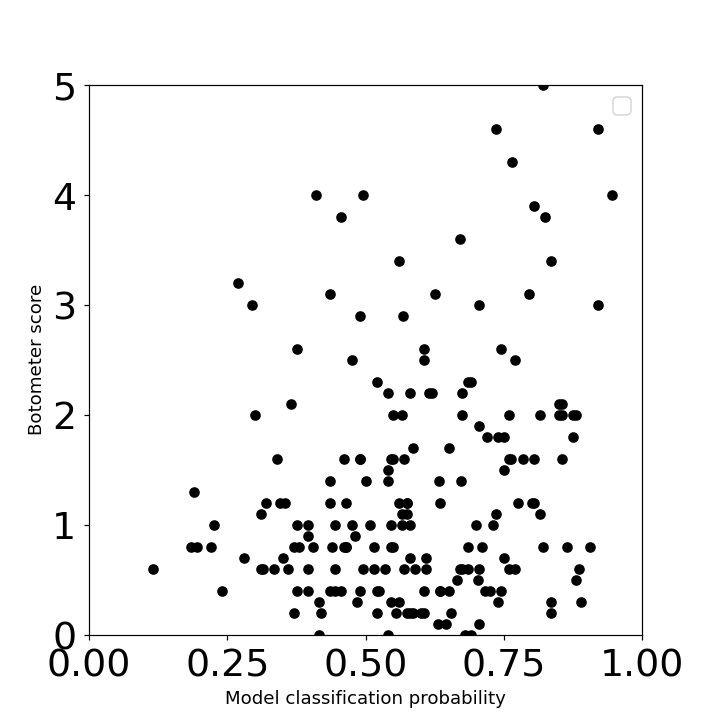

No handles with labels found to put in legend.


In [71]:
from datasets import get_botometer_scores

samples = dataset.sample(200)
print(samples['screen_name'].values)

result = get_botometer_scores(samples['screen_name'])
samples['botometer'] = result

valid_result = samples[samples['botometer'] != -1]



<IPython.core.display.Javascript object>


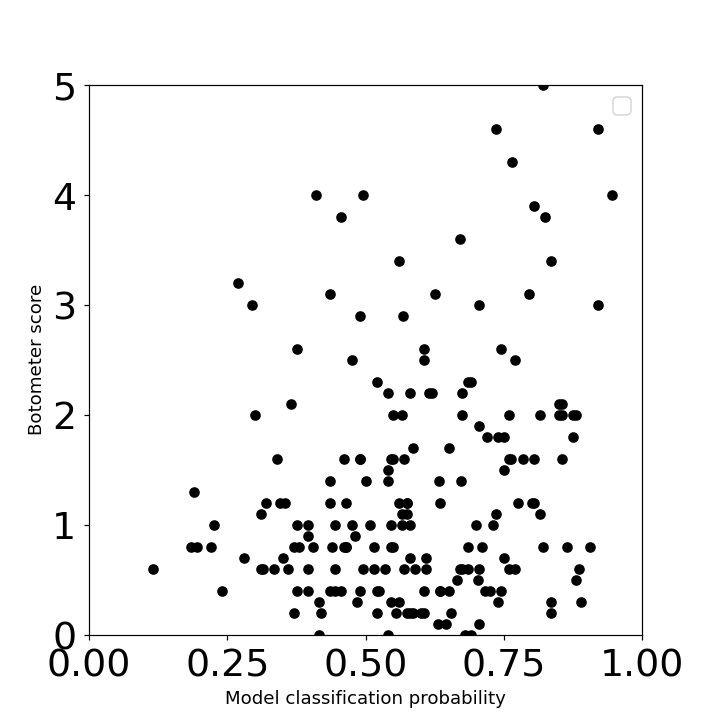

No handles with labels found to put in legend.


(0.2285699487287424, 0.0013876884232378755)
SpearmanrResult(correlation=0.1802542224014799, pvalue=0.012124974800486254)
KendalltauResult(correlation=0.12276629298480352, pvalue=0.013403738534446473)


In [79]:
import datetime
import scipy.stats

current_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

plt.figure(figsize=(6,6))
plt.plot(valid_result['proba'], valid_result['botometer'], 'o', color='black');

plt.ylim(0,5)
plt.xlim(0,1)

plt.xlabel('Model classification probability', fontsize=12)
plt.ylabel('Botometer score', fontsize=12)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

valid_result.to_csv('botometer-score-{}.csv'.format(current_date))

#Pearson correlation
print(scipy.stats.pearsonr(valid_result['proba'], valid_result['botometer']))    # Pearson's r
print(scipy.stats.spearmanr(valid_result['proba'], valid_result['botometer']))  # Spearman's rho
print(scipy.stats.kendalltau(valid_result['proba'], valid_result['botometer']))  # Kendall's tau


In [ ]:
print('Sample of legitimate users:')
total_score = 0
for idx, profile in dataset[bool_mask == 0].sample(10).iterrows():
    print("https://twitter.com/"+str(profile['screen_name']))
    result = bom.check_account(profile['screen_name'])
    print(result['display_scores']['universal']['overall'])
    total_score += int(result['display_scores']['universal']['overall'])
    print("\n")
print("Overall botometer score: " + str(total_score/10.0))

In [ ]:
print('Sample of bot users:')
nb_samples = 10
for idx, profile in dataset[bool_mask == 1].sample(nb_samples).iterrows():
    print("https://twitter.com/"+str(profile['screen_name']))
    result = bom.check_account(profile['screen_name'])
    print(result['display_scores']['universal']['overall'])
    total_score += int(result['display_scores']['universal']['overall'])

    print("\n")
print("Overall botometer score: " + str(total_score/nb_samples))

In [ ]:
plt.figure(figsize=(6,6))
samples = prediction.sample(nb_samples)
_,bins,_ = plt.hist(prediction[prediction < 1], bins=50, label='Legitimate user')
plt.hist(prediction[prediction >= threshold], bins=bins, label='Bots')

plt.xlabel('Model classification probability', fontsize=12)
plt.ylabel('Number of records in each bucket', fontsize=12)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
feature_imp = pd.Series(clf.feature_importances_,index=dataset_model.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Analysis of Twibot-20 dataset
This section is used to analyze the Twibot-20 dataset (https://arxiv.org/abs/2106.13088)

## Load the train and test datasets

In [83]:
from datasets import load_twibot20

twibot20_train = load_twibot20(dataset='train')
twibot20_test = load_twibot20(dataset='test')

## Analyse the datatests

In [84]:
twibot20_train.describe()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,label
count,8.278000e+03,8.278000e+03,8278.000000,8278.000000,8.278000e+03,8278.000000
mean,6.464586e+05,6.609915e+03,1504.488524,13297.475477,2.158684e+04,0.561247
std,4.148888e+06,6.377857e+04,9855.072510,40415.682739,9.008918e+04,0.496265
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,2.010000e+02,2.310000e+02,0.000000,146.000000,4.050000e+02,0.000000
50%,1.939500e+03,7.230000e+02,13.000000,1584.500000,3.624000e+03,1.000000
75%,3.762050e+04,2.124000e+03,258.000000,9121.250000,1.572975e+04,1.000000
max,1.124032e+08,4.339982e+06,550181.000000,783456.000000,5.140025e+06,1.000000


In [85]:
twibot20_test.describe()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,label
count,1.183000e+03,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000
mean,8.231450e+05,6449.619611,1864.894336,12514.628064,21437.875740,0.540997
std,5.577725e+06,40365.824629,9400.150853,29729.397790,57544.176485,0.498527
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.145000e+02,234.500000,1.000000,159.500000,381.000000,0.000000
50%,2.574000e+03,748.000000,17.000000,1884.000000,4051.000000,1.000000
75%,4.764750e+04,2051.500000,331.500000,10001.000000,19556.000000,1.000000
max,8.731376e+07,804528.000000,118656.000000,322238.000000,859809.000000,1.000000


Although the train and test datasets are split into two files, we could merge them together and separate them ourselves.

The train and test datasets have 8278 and 1183 entries, respectively.

In [86]:
twibot20_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8278 entries, 17461978 to 50471224
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   name                          8278 non-null   object             
 1   screen_name                   8278 non-null   object             
 2   location                      8278 non-null   object             
 3   profile_location              728 non-null    object             
 4   description                   8278 non-null   object             
 5   url                           4028 non-null   object             
 6   entities                      8278 non-null   object             
 7   protected                     8278 non-null   bool               
 8   followers_count               8278 non-null   int64              
 9   friends_count                 8278 non-null   int64              
 10  listed_count             

In [87]:
twibot20_train.sample(3)

,name,screen_name,location,profile_location,description,url,entities,protected,followers_count,friends_count,listed_count,created_at,favourites_count,utc_offset,time_zone,geo_enabled,verified,statuses_count,lang,contributors_enabled,is_translator,is_translation_enabled,profile_background_color,profile_background_image_url,profile_background_tile,profile_image_url,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,label,probe_date
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89301054,Carl Regan,CarlRegan17,middlesbrough/stockton,None,#COYG,None,{'description': {'urls': []}},False,48,355,0,2009-11-11 22:28:05+00:00,9955,None,None,True,False,2341,None,False,False,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,False,http://pbs.twimg.com/profile_images/1230625334...,1DA1F2,C0DEED,DDEEF6,333333,True,True,True,False,1,2020-09-06 00:00:00+00:00
26589987,Serena Williams,serenawilliams,Somewhere over the Rainbow,None,"Living, Loving, and working to help you.",https://t.co/eQB8u4IvlO,{'url': {'urls': [{'url': 'https://t.co/eQB8u4...,False,10802460,357,22004,2009-03-25 21:00:33+00:00,581,None,None,True,True,14518,None,False,False,False,642D8B,http://abs.twimg.com/images/themes/theme10/bg....,True,http://pbs.twimg.com/profile_images/8312389695...,FF0000,65B0DA,7AC3EE,3D1957,True,False,False,False,0,2020-09-06 00:00:00+00:00
505219769,Karl Malone,TheDeliverer_32,In the woods or on a boat,None,The Official Twitter of THE MAILMAN,None,{'description': {'urls': []}},False,75242,71,570,2012-02-27 01:03:16+00:00,30,None,None,False,True,348,None,False,False,False,131516,http://abs.twimg.com/images/themes/theme14/bg....,True,http://pbs.twimg.com/profile_images/1098990694...,009999,EEEEEE,EFEFEF,333333,True,False,False,False,0,2020-09-06 00:00:00+00:00


The dataset contains various information provided by the Twitter API. We have access to the account name called "name", the unique username called "screen_name", the location, the description, the number of followers/friends/lists/favorites/statuses, the date of creation, if the account has been verified by Twitter. All the attributes and their description are available at https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user.

Two additional columns are present: the label identifies whether the user is a bot (1) or not (0), the probe_date is used to describe when the data was collected.

Many columns are irrelevant for the detection of bots, we can remove them. We start with the boolean columns:

In [88]:
for col in twibot20_train.select_dtypes(include=['bool']).columns:
    print(f"{col}:")
    print(twibot20_train[col].value_counts())
    print('')

protected:
False    8277
True        1
Name: protected, dtype: int64

geo_enabled:
False    4823
True     3455
Name: geo_enabled, dtype: int64

verified:
False    6221
True     2057
Name: verified, dtype: int64

contributors_enabled:
False    8278
Name: contributors_enabled, dtype: int64

is_translator:
False    8276
True        2
Name: is_translator, dtype: int64

is_translation_enabled:
False    8106
True      172
Name: is_translation_enabled, dtype: int64

profile_background_tile:
False    6895
True     1383
Name: profile_background_tile, dtype: int64

profile_use_background_image:
True     6878
False    1400
Name: profile_use_background_image, dtype: int64

has_extended_profile:
False    5227
True     3051
Name: has_extended_profile, dtype: int64

default_profile:
False    4176
True     4102
Name: default_profile, dtype: int64

default_profile_image:
False    8071
True      207
Name: default_profile_image, dtype: int64



We conclude that the protected column can be removed as the values are mostly False and it has been deprecated by the Twitter API. We can remove contributors_enabled, is_translation_enabled, is_translator and profile_location for the same reasons.

We also remove columns that only contain empty values and irrelevant columns (colors, profile/background urls). 

In [89]:
from datasets import remove_useless_api_columns

twibot20_train = remove_useless_api_columns(twibot20_train)
twibot20_test = remove_useless_api_columns(twibot20_test)
twibot20_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8278 entries, 17461978 to 50471224
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   name                          8278 non-null   object             
 1   screen_name                   8278 non-null   object             
 2   location                      8278 non-null   object             
 3   description                   8278 non-null   object             
 4   url                           4028 non-null   object             
 5   followers_count               8278 non-null   int64              
 6   friends_count                 8278 non-null   int64              
 7   listed_count                  8278 non-null   int64              
 8   created_at                    8278 non-null   datetime64[ns, UTC]
 9   favourites_count              8278 non-null   int64              
 10  geo_enabled              

## Feature engineering
At the moment we are somewhat limited in the number of available features. We will use feature engineering with methods found in (https://arxiv.org/abs/1911.09179), as well as our own features.

(https://arxiv.org/abs/1911.09179) adds the user_age, tweet_freq, followers/friends/favourites/listed_growth_rate, followers_friends_ratio, (screen_)name_length, description_length, num_digits_in_(screen_)name. We also replace location and url by two booleans indicating whether the field is non-null.

In [90]:
from datasets import feature_engineering

twibot20_train = feature_engineering(twibot20_train)
twibot20_train.sort_index(axis=1, inplace=True)

twibot20_test = feature_engineering(twibot20_test)
twibot20_test.sort_index(axis=1, inplace=True)
twibot20_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8278 entries, 17461978 to 50471224
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   created_at                    8278 non-null   datetime64[ns, UTC]
 1   default_profile               8278 non-null   bool               
 2   default_profile_image         8278 non-null   bool               
 3   description                   8278 non-null   object             
 4   description_length            8278 non-null   int64              
 5   favourites_count              8278 non-null   int64              
 6   favourites_growth_rate        8278 non-null   float64            
 7   followers_count               8278 non-null   int64              
 8   followers_friends_ratio       8278 non-null   float64            
 9   followers_growth_rate         8278 non-null   float64            
 10  friends_count            

In [91]:
twibot20_train.describe()

,description_length,favourites_count,favourites_growth_rate,followers_count,followers_friends_ratio,followers_growth_rate,friends_count,friends_growth_rate,label,listed_count,listed_growth_rate,name_length,num_digits_in_name,num_digits_in_screen_name,screen_name_length,statuses_count,tweet_freq,user_age
count,8278.000000,8278.000000,8278.000000,8.278000e+03,8.278000e+03,8278.000000,8.278000e+03,8278.000000,8278.000000,8278.000000,8.278000e+03,8278.000000,8278.000000,8278.000000,8278.000000,8.278000e+03,8278.000000,8.278000e+03
mean,83.046146,13297.475477,0.000094,6.464586e+05,2.860677e+04,0.002140,6.609915e+03,0.000039,0.561247,1504.488524,4.554513e-06,14.057381,0.104011,0.764557,12.139889,2.158684e+04,0.000096,2.230634e+08
std,55.984721,40415.682739,0.000317,4.148888e+06,9.288078e+05,0.012462,6.377857e+04,0.000233,0.496265,9855.072510,2.688255e-05,6.125798,0.596134,1.756609,2.710466,9.008918e+04,0.000321,1.229977e+08
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.000000,0.000000,0.000000,3.000000,0.000000e+00,0.000000,1.442620e+05
25%,30.000000,146.000000,0.000001,2.010000e+02,3.266071e-01,0.000002,2.310000e+02,0.000001,0.000000,0.000000,0.000000e+00,11.000000,0.000000,0.000000,10.000000,4.050000e+02,0.000003,1.153540e+08
50%,86.000000,1584.500000,0.000009,1.939500e+03,1.040150e+00,0.000012,7.230000e+02,0.000004,1.000000,13.000000,7.091948e-08,14.000000,0.000000,0.000000,12.000000,3.624000e+03,0.000019,2.493283e+08
75%,138.000000,9121.250000,0.000051,3.762050e+04,2.620716e+01,0.000180,2.124000e+03,0.000014,1.000000,258.000000,1.075070e-06,17.000000,0.000000,1.000000,14.000000,1.572975e+04,0.000073,3.348414e+08
max,202.000000,783456.000000,0.006245,1.124032e+08,5.828524e+07,0.311287,4.339982e+06,0.012088,1.000000,550181.000000,1.523659e-03,51.000000,10.000000,13.000000,16.000000,5.140025e+06,0.015001,4.563762e+08


In [92]:
twibot20_train.sample(5)

,created_at,default_profile,default_profile_image,description,description_length,favourites_count,favourites_growth_rate,followers_count,followers_friends_ratio,followers_growth_rate,friends_count,friends_growth_rate,geo_enabled,has_url,label,listed_count,listed_growth_rate,location,name,name_length,num_digits_in_name,num_digits_in_screen_name,probe_date,profile_background_tile,profile_use_background_image,screen_name,screen_name_length,statuses_count,tweet_freq,url,user_age,verified
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19980499,2009-02-03 16:15:56+00:00,False,False,Official account of the ATP Tour 🎾,35,12891,3.525284e-05,1590960,2752.525952,4.350777e-03,578,1.580649e-06,True,True,0,9781,2.674797e-05,,ATP Tour,9,0,0,2020-09-06 00:00:00+00:00,False,True,atptour,8,48478,1.325721e-04,https://t.co/QtczzuJwSK,365672644.0,True
31173122,2009-04-14 17:25:13+00:00,False,False,Fashion Marketing student. Nottingham Trent Un...,115,4,1.112284e-08,90,0.661765,2.502638e-07,136,3.781765e-07,True,True,1,5,1.390355e-08,"Hertfordshire, England",Rachel Murtagh,15,0,0,2020-09-06 00:00:00+00:00,True,True,murtaghlove,12,199,5.533611e-07,http://t.co/08oM2FrKhI,359620487.0,False
248536763,2011-02-07 06:13:05+00:00,False,False,"pushing blocks, growing ideas, educating and s...",52,230,7.608557e-07,229,0.512304,7.575477e-07,447,1.478707e-06,False,True,1,20,6.616137e-08,Chicago,"MOV AX, 04C00h",15,4,0,2020-09-06 00:00:00+00:00,False,True,matthewpkemp,13,3764,1.245157e-05,https://t.co/gp32eTgHm7,302291215.0,False
1077790424645816320,2018-12-26 04:57:16+00:00,False,False,"Singer,Dancer,Swimmer,Gamer, all of the above....",105,763,1.424832e-05,267,0.480216,4.985979e-06,556,1.038279e-05,False,False,1,1,1.867408e-08,"Roxas City, Western Visayas",James Shop,11,0,0,2020-09-06 00:00:00+00:00,False,False,JaimeNucido,12,1084,2.024270e-05,None,53550164.0,False
28327049,2009-04-02 12:23:11+00:00,False,False,The Wall Street Journal's tireless sports nerd...,149,116,3.216188e-07,68101,308.149321,1.888152e-04,221,6.127393e-07,False,True,0,1947,5.398206e-06,New York City,WSJ Sports,11,0,0,2020-09-06 00:00:00+00:00,True,False,WSJSports,10,28690,7.954521e-05,http://t.co/8fGxjkAQW8,360675409.0,True


In [93]:
twibot20_train[twibot20_train['tweet_freq'] > 100]

,created_at,default_profile,default_profile_image,description,description_length,favourites_count,favourites_growth_rate,followers_count,followers_friends_ratio,followers_growth_rate,friends_count,friends_growth_rate,geo_enabled,has_url,label,listed_count,listed_growth_rate,location,name,name_length,num_digits_in_name,num_digits_in_screen_name,probe_date,profile_background_tile,profile_use_background_image,screen_name,screen_name_length,statuses_count,tweet_freq,url,user_age,verified
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Analysis of the features


In [94]:
print("Train dataset")
print("Number of users: {}".format(len(twibot20_train)))
print("Number of verified users: {}".format(twibot20_train['verified'].sum()))

Train dataset
Number of users: 8278
Number of verified users: 2057


In [95]:
print("Test dataset")
print("Number of users: {}".format(len(twibot20_test)))
print("Number of verified users: {}".format(twibot20_test['verified'].sum()))

Test dataset
Number of users: 1183
Number of verified users: 326


In [96]:
print('Sample of legitimate users:')
for idx, profile in twibot20_train[twibot20_train['label'] == 0].sample(10).iterrows():
    print("https://twitter.com/"+str(profile['screen_name']))

Sample of legitimate users:
https://twitter.com/KurtPelda 
https://twitter.com/allontheline_nj 
https://twitter.com/BanosCdmx 
https://twitter.com/Windows 
https://twitter.com/Wayne34458595 
https://twitter.com/t_mordecai 
https://twitter.com/AmroucheMarouan 
https://twitter.com/JamesPearceLFC 
https://twitter.com/alvxaro 
https://twitter.com/GrillCheese49 


In [97]:
print('Sample of bots:')
for idx, profile in twibot20_train[twibot20_train['label'] == 1].sample(10).iterrows():
    print("https://twitter.com/"+str(profile['screen_name']))

Sample of bots:
https://twitter.com/rohit_x_ 
https://twitter.com/BaBieGirlieGirl 
https://twitter.com/SarahBo18687778 
https://twitter.com/intenseCA 
https://twitter.com/MariusSoU 
https://twitter.com/XoxoAshleyyyyy 
https://twitter.com/mrjafri 
https://twitter.com/PriyankSavla 
https://twitter.com/henrybschwab 
https://twitter.com/expressoshow 


### 2D PCA analysis

<IPython.core.display.Javascript object>


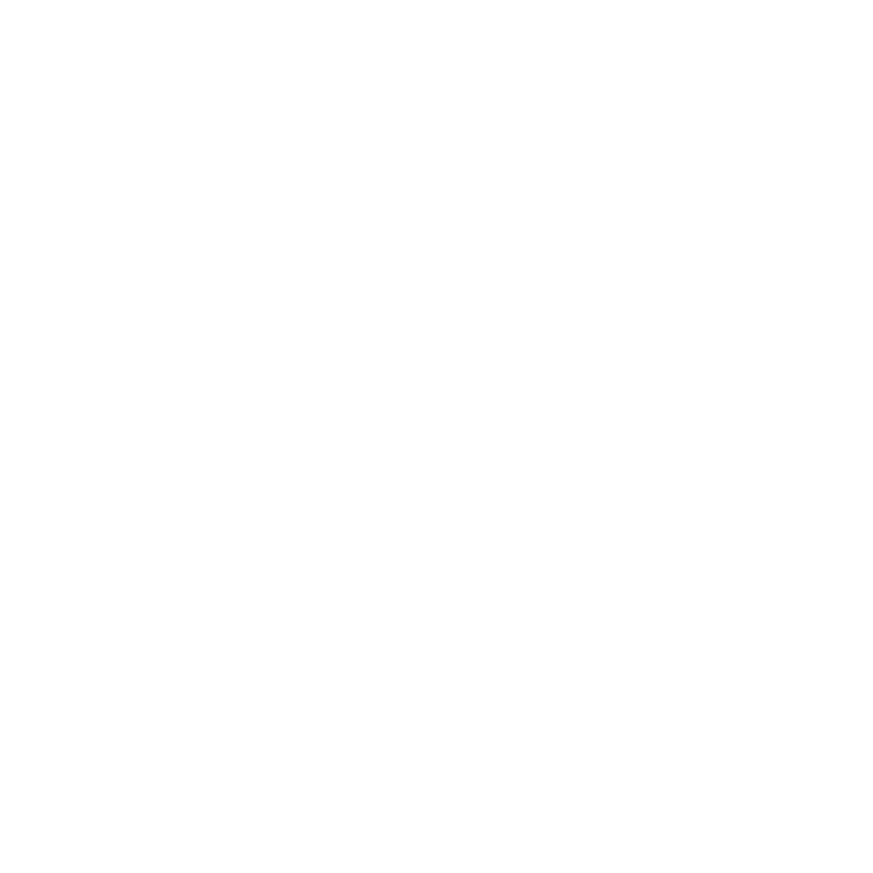

In [98]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

def draw_pca(data):
    # PCA analysis only on bool, int64 and float64
    X_raw = data.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
    sc = StandardScaler()
    sc.fit(X_raw)
    
    X = sc.transform(X_raw)    
    y = data['label']

    fig = plt.figure(1, figsize=(8, 8))
    ax = fig.add_subplot(1,1,1)

    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    X = pca.transform(X)

    for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
        ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

    ax.grid()
    plt.show()

%matplotlib notebook
draw_pca(twibot20_train)
#draw_pca(dataset)

### Analysis of the annotation
Quality of the annotation using global data

In [99]:

# Account reputation based on Chu et al 
def reputation(user):
    a = abs(user['followers_count'])
    b = abs(user['followers_count']) + abs(user['friends_count'])
    
    return a / b if b != 0 else 0

In [100]:
print('Mean reputation of twibot20_train: {}'.format(twibot20_train.apply(reputation, axis=1).mean()))
print('Mean reputation of twibot20_test : {}\n'.format(twibot20_test.apply(reputation, axis=1).mean()))

print('Mean reputation of bots in twibot20_train: {}'.format(twibot20_train[twibot20_train['label'] == 1].apply(reputation, axis=1).mean()))
print('Mean reputation of bots in twibot20_test : {}\n'.format(twibot20_test[twibot20_test['label'] == 1].apply(reputation, axis=1).mean()))

print('Mean reputation of users in twibot20_train: {}'.format(twibot20_train[twibot20_train['label'] == 0].apply(reputation, axis=1).mean()))
print('Mean reputation of users in twibot20_test : {}'.format(twibot20_test[twibot20_test['label'] == 0].apply(reputation, axis=1).mean()))

Mean reputation of twibot20_train: 0.5674009934923678
Mean reputation of twibot20_test : 0.5790589291082501

Mean reputation of bots in twibot20_train: 0.43975627325969846
Mean reputation of bots in twibot20_test : 0.4337614723965223

Mean reputation of users in twibot20_train: 0.7306822077547604
Mean reputation of users in twibot20_test : 0.7503119167611143


### Random forest model

In [101]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

# PCA analysis only on bool, int64 and float64
X_train = twibot20_train.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_train = twibot20_train['label']

X_test = twibot20_test.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_test = twibot20_test['label']

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train.values, y_train.values)

y_pred=clf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8148774302620456


In [102]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

verified                        0.208603
followers_friends_ratio         0.091484
followers_count                 0.084074
listed_count                    0.066346
followers_growth_rate           0.061325
user_age                        0.055576
statuses_count                  0.049359
friends_count                   0.048775
favourites_count                0.042663
description_length              0.042515
friends_growth_rate             0.040060
tweet_freq                      0.039451
favourites_growth_rate          0.037277
name_length                     0.033878
screen_name_length              0.026633
listed_growth_rate              0.024997
num_digits_in_screen_name       0.013708
geo_enabled                     0.009722
has_url                         0.009140
default_profile                 0.007328
profile_use_background_image    0.003752
num_digits_in_name              0.003334
dtype: float64

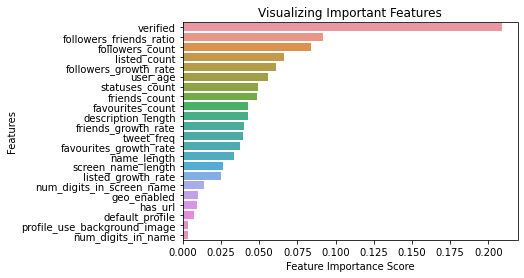

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [104]:
bots_pred = clf.predict(dataset_model.sort_index(axis=1).select_dtypes(include=['int64', 'float64', 'bool']))
bots_pred.sum()

ValueError: X has 21 features, but DecisionTreeClassifier is expecting 22 features as input.

# Cresci-2017 dataset
## Loading the dataset

In [ ]:
from datasets import load_cresci17
cresci17_raw = load_cresci17()
cresci17_raw.describe()

In [ ]:
from datasets import remove_cresci17_extra_columns

cresci17 = feature_engineering(remove_useless_api_columns(remove_cresci17_extra_columns(cresci17_raw)))
cresci17.sort_index(axis=1, inplace=True)
cresci17.info()

## PCA analysis

In [ ]:
cresci17.describe()

In [ ]:
%matplotlib notebook
draw_pca(cresci17)

In [ ]:
print('Mean reputation of cresci17 : {}\n'.format(cresci17.apply(reputation, axis=1).mean()))

print('Mean reputation of bots in cresci17 : {}\n'.format(cresci17[cresci17['label'] == 1].apply(reputation, axis=1).mean()))

print('Mean reputation of users in cresci17 : {}'.format(cresci17[cresci17['label'] == 0].apply(reputation, axis=1).mean()))

## Random forest model

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test
X = cresci17.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y = cresci17['label']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train.values, y_train.values)

y_pred=clf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [ ]:
X_test['verified'].value_counts()

# Midterm-2018 dataset

In [ ]:
from datasets import load_midterm18
midterm18_raw = load_midterm18()
midterm18_raw.info()

In [ ]:
midterm18_raw.sample(3)

In [ ]:
from datasets import remove_midterm18_extra_columns

midterm18 = feature_engineering(remove_useless_api_columns(remove_midterm18_extra_columns(midterm18_raw)))
midterm18.sort_index(axis=1, inplace=True)
midterm18.info()

In [ ]:
midterm18.describe()

We can see that some features (profile_background_tile, location, default_profile_image) are missing from the dataset compared to TwiBot-20 and Cresci-17. This will have to be taken into consideration when mixing datasets.

### PCA analysis

In [ ]:
%matplotlib notebook
draw_pca(midterm18)

In [ ]:
print('Mean reputation of midterm18 : {}\n'.format(midterm18.apply(reputation, axis=1).mean()))

print('Mean reputation of bots in midterm18 : {}\n'.format(midterm18[midterm18['label'] == 1].apply(reputation, axis=1).mean()))

print('Mean reputation of users in midterm18 : {}'.format(midterm18[midterm18['label'] == 0].apply(reputation, axis=1).mean()))

## Random forest model

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test
X = midterm18.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y = midterm18['label']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train.values, y_train.values)

y_pred=clf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Mixing datasets
### Generalization capabilities

First, let's see whether the models trained on a dataset works on other datasets.

In [ ]:
twibot20_bots = twibot20_train[twibot20_train['label'] == 1].apply(reputation, axis=1)
twibot20_users = twibot20_train[twibot20_train['label'] == 0].apply(reputation, axis=1)

cresci17_bots = cresci17[cresci17['label'] == 1].apply(reputation, axis=1)
cresci17_users = cresci17[cresci17['label'] == 0].apply(reputation, axis=1)

midterm18_bots = midterm18[midterm18['label'] == 1].apply(reputation, axis=1)
midterm18_users = midterm18[midterm18['label'] == 0].apply(reputation, axis=1)

dataset_rep = dataset_model.apply(reputation, axis=1)

In [ ]:
data = [twibot20_bots.values, cresci17_bots.values, midterm18_bots.values, twibot20_users.values, cresci17_users.values, midterm18_users.values, dataset_rep.values]
labels = ['TwiBot-20 Bot', 'Cresci-17 Bot', 'Midterm-18 Bot', 'TwiBot-20 User', 'Cresci-17 User', 'Midterm-18 User', 'Dataset']

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Reputation distribution of datasets')
ax.boxplot(data)
ax.set_xticklabels(labels);

In [ ]:
print('Mean reputation of twibot20 : {}'.format(twibot20_train.apply(reputation, axis=1).mean()))
print('Mean reputation of bots in twibot20 : {}'.format(twibot20_train[twibot20_train['label'] == 1].apply(reputation, axis=1).mean()))
print('Mean reputation of users in twibot20 : {}\n'.format(twibot20_train[twibot20_train['label'] == 0].apply(reputation, axis=1).mean()))

print('Mean reputation of cresci17 : {}'.format(cresci17.apply(reputation, axis=1).mean()))
print('Mean reputation of bots in cresci17 : {}'.format(cresci17[cresci17['label'] == 1].apply(reputation, axis=1).mean()))
print('Mean reputation of users in cresci17 : {}\n'.format(cresci17[cresci17['label'] == 0].apply(reputation, axis=1).mean()))

print('Mean reputation of midterm18 : {}'.format(midterm18.apply(reputation, axis=1).mean()))
print('Mean reputation of bots in midterm18 : {}'.format(midterm18[midterm18['label'] == 1].apply(reputation, axis=1).mean()))
print('Mean reputation of users in midterm18 : {}\n'.format(midterm18[midterm18['label'] == 0].apply(reputation, axis=1).mean()))

In [ ]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

%matplotlib notebook

twibot20_pca = twibot20_train.sample(200).copy()
cresci17_pca = cresci17.sample(200).copy()
midterm18_pca = midterm18.sample(200).copy()

twibot20_pca['label'] = twibot20_pca['label'].apply(lambda lbl: ('twibot20', lbl))
cresci17_pca['label'] = cresci17_pca['label'].apply(lambda lbl: ('cresci17', lbl))
midterm18_pca['label'] = midterm18_pca['label'].apply(lambda lbl: ('midterm18', lbl))

data = pd.concat([twibot20_pca, cresci17_pca, midterm18_pca])
X_raw = data.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])

sc = StandardScaler()
sc.fit(X_raw)
X = sc.transform(X_raw)
y = data['label']

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

colors = [(("twibot20", 0), 'green'), (("twibot20", 1), 'lime'),
          (("cresci17", 0), 'blue'), (("cresci17", 1), 'cyan'),
          (("midterm18", 0), 'purple'), (("midterm18", 1), 'magenta')]
for label, c in colors:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.show()


twibot20_pca = twibot20_pca[0:0]
cresci17_pca = cresci17_pca[0:0]
midterm18_pca = midterm18_pca[0:0]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test
# Drop columns missing from midterm18
X_twibot20 = twibot20_train.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_twibot20 = twibot20_train['label']
X_twibot20_train, X_twibot20_test, y_twibot20_train, y_twibot20_test = train_test_split(X_twibot20, y_twibot20,test_size=0.33, random_state=80)

X_cresci17 = cresci17.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_cresci17 = cresci17['label']
X_cresci17_train, X_cresci17_test, y_cresci17_train, y_cresci17_test = train_test_split(X_cresci17, y_cresci17,test_size=0.33, random_state=80)

X_midterm18 = midterm18.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_midterm18 = midterm18['label']
X_midterm18_train, X_midterm18_test, y_midterm18_train, y_midterm18_test = train_test_split(X_midterm18, y_midterm18,test_size=0.33, random_state=80)

#### Model trained using TwiBot-20

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_twibot20_train, y_twibot20_train)

y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)
y_midterm18_pred=clf.predict(X_midterm18_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of twibot20   :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print("                     f1:", metrics.f1_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17   :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print("                     f1:", metrics.f1_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))
print("Accuracy on midterm18  :", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print("                     f1:", metrics.f1_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))

"""
              pred
            1       0
          -----   -----
       1 |  TP  |  FP
truth     -----   -----
       0 |  FN  |  TN
""";

In [ ]:
y_twibot20_test.sum()

#### Model trained using Cresci-17

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_cresci17_train, y_cresci17_train)

y_cresci17_pred=clf.predict(X_cresci17_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_midterm18_pred=clf.predict(X_midterm18_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))

#### Model trained using Midterm-18

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_midterm18_train, y_midterm18_train)

y_midterm18_pred=clf.predict(X_midterm18_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

In [ ]:
# Use only 5000 sample of each
from sklearn.model_selection import train_test_split

rand = 346
# Split the dataset into train, test
twibot20_sample = twibot20_train.sample(8000, random_state=rand)
cresci17_sample = cresci17.sample(3000, random_state=rand)
midterm18_sample = midterm18.sample(5000, random_state=rand)

# Drop columns missing from midterm18
X_twibot20 = twibot20_sample.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_twibot20 = twibot20_sample['label']
X_twibot20_train, X_twibot20_test, y_twibot20_train, y_twibot20_test = train_test_split(X_twibot20, y_twibot20,test_size=0.33, random_state=80)

X_cresci17 = cresci17_sample.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_cresci17 = cresci17_sample['label']
X_cresci17_train, X_cresci17_test, y_cresci17_train, y_cresci17_test = train_test_split(X_cresci17, y_cresci17,test_size=0.33, random_state=80)

X_midterm18 = midterm18_sample.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_midterm18 = midterm18_sample['label']
X_midterm18_train, X_midterm18_test, y_midterm18_train, y_midterm18_test = train_test_split(X_midterm18, y_midterm18,test_size=0.33, random_state=80)

In [ ]:
# Cresci + midterm dataset
X_cresci17_midterm18_train = pd.concat([X_cresci17_train, X_midterm18_train])
y_cresci17_midterm18_train = pd.concat([y_cresci17_train, y_midterm18_train])

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_cresci17_midterm18_train, y_cresci17_midterm18_train)

y_midterm18_pred=clf.predict(X_midterm18_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

In [ ]:
# Twibot + cresci dataset
X_twibot20_cresci17_train = pd.concat([X_twibot20_train, X_cresci17_train ])
y_twibot20_cresci17_train = pd.concat([y_twibot20_train, y_cresci17_train])

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_twibot20_cresci17_train, y_twibot20_cresci17_train)

y_midterm18_pred=clf.predict(X_midterm18_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

In [ ]:
# Twibot + midterm dataset
X_twibot20_midterm18_train = pd.concat([X_twibot20_train, X_cresci17_train ])
y_twibot20_midterm18_train = pd.concat([y_twibot20_train, y_cresci17_train])

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_twibot20_midterm18_train, y_twibot20_midterm18_train)

y_midterm18_pred=clf.predict(X_midterm18_test)
y_twibot20_pred=clf.predict(X_twibot20_test)
y_cresci17_pred=clf.predict(X_cresci17_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

## Training without 'verified' feature

In [ ]:
# Twibot + midterm dataset
X_twibot20_midterm18_train = pd.concat([X_twibot20_train, X_cresci17_train ]).drop(columns=['verified'])
y_twibot20_midterm18_train = pd.concat([y_twibot20_train, y_cresci17_train]).drop(columns=['verified'])

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200, class_weight='balanced')

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_twibot20_midterm18_train, y_twibot20_midterm18_train)

y_midterm18_pred=clf.predict(X_midterm18_test.drop(columns=['verified']))
y_twibot20_pred=clf.predict(X_twibot20_test.drop(columns=['verified']))
y_cresci17_pred=clf.predict(X_cresci17_test.drop(columns=['verified']))

# Model Accuracy, how often is the classifier correct?
print("Accuracy of midterm18:", metrics.accuracy_score(y_midterm18_test, y_midterm18_pred))
print(metrics.confusion_matrix(y_midterm18_test, y_midterm18_pred, labels=[1, 0]))
print("Accuracy on twibot20 :", metrics.accuracy_score(y_twibot20_test, y_twibot20_pred))
print(metrics.confusion_matrix(y_twibot20_test, y_twibot20_pred, labels=[1, 0]))
print("Accuracy on cresci17 :", metrics.accuracy_score(y_cresci17_test, y_cresci17_pred))
print(metrics.confusion_matrix(y_cresci17_test, y_cresci17_pred, labels=[1, 0]))

In [ ]:
# Extract the model
import joblib
joblib.dump(clf, 'rf-model.pkl')

In [ ]:
# Restore the model
import joblib
clf_copy = joblib.load('rf-model.pkl')

In [ ]:
X_verified19 = verified19.drop(['label', 'location', 'profile_background_tile', 'default_profile_image'], axis=1).select_dtypes(include=['int64', 'float64', 'bool'])
y_verified19 = verified19['label']

clf.predict(X_verified19).sum()

In [ ]:
clf.predict(twibot20_train[twibot20_train['name'] == 'OConnellFanClub '].values)

In [ ]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

%matplotlib notebook

twibot20_pca = twibot20_train.sample(200).copy()
cresci17_pca = cresci17.sample(200).copy()
midterm18_pca = midterm18.sample(200).copy()
dataset_pca = dataset_model.sample(200).copy()
dataset_pca['label'] = 0

twibot20_pca['label'] = twibot20_pca['label'].apply(lambda lbl: ('twibot20', lbl))
cresci17_pca['label'] = cresci17_pca['label'].apply(lambda lbl: ('cresci17', lbl))
#midterm18_pca['label'] = midterm18_pca['label'].apply(lambda lbl: ('midterm18', lbl))
dataset_pca['label'] = dataset_pca['label'].apply(lambda lbl: ('dataset', lbl))

data = pd.concat([twibot20_pca, cresci17_pca, dataset_pca])
X_raw = data.drop('label', axis=1).select_dtypes(include=['int64', 'float64', 'bool'])

sc = StandardScaler()
sc.fit(X_raw)
X = sc.transform(X_raw)
y = data['label']

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

colors = [(("twibot20", 0), 'green'), (("twibot20", 1), 'lime'),
          (("cresci17", 0), 'blue'), (("cresci17", 1), 'cyan'),
          (("dataset", 0), 'purple'), (("dataset", 1), 'magenta')]
for label, c in colors:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.show()


twibot20_pca = twibot20_pca[0:0]
cresci17_pca = cresci17_pca[0:0]
midterm18_pca = midterm18_pca[0:0]

# Random code

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

Y_train = train_features['label']
X_train = train_features.drop(['label'], axis=1)

Y_test = test_features['label']
X_test = test_features.drop(['label'], axis=1)
# Split dataset into training set and test set

X_test.info()

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values,Y_train.values)

y_pred=clf.predict(X_test.values)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
profiles = [profile for profile in train_raw_data[train_raw_data["label"] == 0].sample(n=30)["profile"]]
for profile in profiles:
    print("https://twitter.com/"+str(profile['screen_name'])+"\n")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = train_features.drop(['label'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = train_features['label']

fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = train_features.drop(['label'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = train_features['label']

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
    ax.scatter(X[y == label, 0], X[y == label, 1], X[y == label, 2], c=c, alpha=0.7)
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
#ax.scatter(X[y , 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="c")

ax.set_xlim3d(-10,20)
ax.set_zlim3d(-10,10)

fig.add_axes(ax)

plt.show()

In [ ]:
%matplotlib notebook

import pandas as pd
import numpy as np

files_genuine = ["../cresci-2017.csv/genuine_accounts.csv/users.csv"]
files_bots = ["../cresci-2017.csv/traditional_spambots_1.csv/users.csv",
              "../cresci-2017.csv/traditional_spambots_2.csv/users.csv",
              "../cresci-2017.csv/traditional_spambots_3.csv/users.csv",
              "../cresci-2017.csv/traditional_spambots_4.csv/users.csv",
              "../cresci-2017.csv/social_spambots_1.csv/users.csv",
              "../cresci-2017.csv/social_spambots_2.csv/users.csv",
              "../cresci-2017.csv/social_spambots_3.csv/users.csv"]

train_raw_data_genuine = pd.concat((pd.read_csv(f) for f in files_genuine))
train_raw_data_genuine['label'] = 0

train_raw_data_bots = pd.concat((pd.read_csv(f) for f in files_bots))
train_raw_data_bots['label'] = 1

train_raw_data = pd.concat((train_raw_data_genuine, train_raw_data_bots))
train_raw_data = train_raw_data.rename(columns={})

train_profile = train_raw_data

train_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]] = train_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]].apply(pd.to_numeric, errors='coerce', axis=1)

train_profile.set_index('id', inplace=True)

#Douteux
#train_profile = train_profile.replace([0], 1)

def date_converter(dt):
    try:
        return pd.to_datetime(dt)
    except:
        return pd.to_datetime("1185440851000", unit="ms", utc=True)

train_profile.created_at = train_profile.created_at.apply(date_converter)

train_labels = train_raw_data["label"].values
train_dict = {"statuses_count":train_profile.statuses_count, 
                "followers_count":train_profile.followers_count, 
                "friends_count":train_profile.friends_count, 
                "favourites_count":train_profile.favourites_count, 
                "listed_count":train_profile.listed_count, 
                "default_profile":train_profile.default_profile,
                "profile_use_background_image":train_profile.profile_use_background_image,
                "verified":train_profile.verified,
                "user_age":(pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days,
                "tweet_freq": np.nan_to_num(train_profile.statuses_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "followers_growth_rate": np.nan_to_num(train_profile.followers_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "friends_growth_rate" : np.nan_to_num(train_profile.friends_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "favourites_growth_rate" : np.nan_to_num(train_profile.favourites_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "listed_growth_rate" : np.nan_to_num(train_profile.listed_count / (pd.to_datetime(train_profile.updated, utc=True) - pd.to_datetime(train_profile.created_at)).dt.days),
                "followers_friends_ratio" : np.nan_to_num(train_profile.followers_count / train_profile.friends_count, posinf=0.0),
                "screen_name_length": train_profile.screen_name.str.len(),
                "num_digits_in_screen_name": train_profile.screen_name.str.count('\d'),
                "name_length": train_profile.name.str.len(),
                "num_digits_in_name": train_profile.name.str.count('\d'),
                "description_length": train_profile.description.str.len(),
                 "label":train_labels
               }
train_features2 = pd.DataFrame(data=train_dict)
train_features2 = train_features2.replace({'True ': True, 'False ': False})
train_features2 = train_features2.fillna(0)
train_features2.default_profile = train_features2.default_profile.astype(bool)
train_features2.verified = train_features2.verified.astype(bool)
train_features2.profile_use_background_image = train_features2.profile_use_background_image.astype(bool)

train_features2.describe()

In [ ]:
train_profile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = train_features2.drop(['label', 'verified'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = train_features2['label']

fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = train_features2.drop(['label'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = train_features2['label']

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
    ax.scatter(X[y == label, 0], X[y == label, 1], X[y == label, 2], c=c, alpha=0.7)
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
#ax.scatter(X[y , 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="c")


fig.add_axes(ax)
ax.set_xlim3d(0,50)
ax.set_ylim3d(-10,30)
ax.set_zlim3d(-10,10)


plt.show()

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

y = train_features2['label']
X = train_features2.drop(['label'], axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

X_test.info()

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
y_test = test_features['label']
X_test = test_features.drop(['label'], axis=1)

y_pred = clf.predict(X_test.values)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
indexes = X_test[y_pred == 1].index
profiles = test_profile.loc[test_profile.index.isin(indexes)]
for i, profile in profiles.iterrows():
    print("https://twitter.com/"+profile.screen_name+"\n")

In [ ]:
profiles.values

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
# Applying to a human dataset
def load_verified_2019():
    file_users = "../verified-2019/verified-2019_tweets.json"
    file_bots = "../verified-2019/verified-2019.tsv"

    raw = pd.read_json(file_users)
    labels = pd.read_csv(file_bots, names=['id', 'label'], sep='\t')    

    profiles = pd.json_normalize(raw['user'])
    profiles.drop(['id_str', 
                   'profile_background_image_url_https', 
                   'profile_image_url_https'], axis=1, inplace=True)
    profiles['label'] = 0
    profiles['probe_date'] = raw['created_at']

    # Convert columns to integer
    profiles[['id', 'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count', 'label']] = profiles[['id', 'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count', 'label']].apply(pd.to_numeric)
    profiles.set_index('id', inplace=True)

    # Convert strings to dates
    profiles['created_at'] = profiles['created_at'].apply(pd.to_datetime, utc=True)
    profiles['probe_date'] = profiles['probe_date'].apply(pd.to_datetime, utc=True)

    # Replace "True ", "False ", "None " by python types
    profiles.replace({'True ': True, 'False ': False, 'None ': None}, inplace=True)

    return profiles

verified19 = feature_engineering(remove_useless_api_columns(load_verified_2019()))
verified19.drop(['notifications', 'following', 'profile_banner_url', 'translator_type', 'entities.url.urls', 'entities.description.urls', 'follow_request_sent'], axis=1, inplace=True)
verified19.sort_index(axis=1, inplace=True)
verified19.info()

In [ ]:
%matplotlib notebook

import pandas as pd
import numpy as np

file_users = "../midterm-2018_processed_user_objects.json"
file_bots = "../midterm-2018.tsv"

midterm2018_profile = pd.read_json(file_users)
midterm2018_labels = pd.read_csv(file_bots, names=['id', 'label'], sep='\t')

midterm2018_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]] = midterm2018_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]].apply(pd.to_numeric, errors='coerce', axis=1)

midterm2018_profile = midterm2018_profile.rename(columns={'user_id': 'id'})

midterm2018_profile.set_index('id', inplace=True)
midterm2018_labels.set_index('id', inplace=True)

def date_converter(dt):
    try:
        return pd.to_datetime(dt)
    except:
        return pd.to_datetime("1185440851000", unit="ms")

midterm2018_profile.probe_timestamp = midterm2018_profile.probe_timestamp.apply(date_converter)
midterm2018_labels.label = midterm2018_labels.label.apply(lambda l: 1 if l == 'bot' else 0)

In [ ]:
midterm2018_dict = {"statuses_count":midterm2018_profile.statuses_count, 
                "followers_count":midterm2018_profile.followers_count, 
                "friends_count":midterm2018_profile.friends_count, 
                "favourites_count":midterm2018_profile.favourites_count, 
                "listed_count":midterm2018_profile.listed_count, 
                "default_profile":midterm2018_profile.default_profile,
                "profile_use_background_image":midterm2018_profile.profile_use_background_image,
                "verified":midterm2018_profile.verified,
                "user_age":(pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days,
                "tweet_freq": np.nan_to_num(midterm2018_profile.statuses_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "followers_growth_rate": np.nan_to_num(midterm2018_profile.followers_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "friends_growth_rate" : np.nan_to_num(midterm2018_profile.friends_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "favourites_growth_rate" : np.nan_to_num(midterm2018_profile.favourites_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "listed_growth_rate" : np.nan_to_num(midterm2018_profile.listed_count / (pd.to_datetime(midterm2018_profile.probe_timestamp) - pd.to_datetime(midterm2018_profile.user_created_at)).dt.days, posinf=0.0),
                "followers_friends_ratio" : np.nan_to_num(midterm2018_profile.followers_count / midterm2018_profile.friends_count, posinf=0.0),
                "screen_name_length": midterm2018_profile.screen_name.str.len(),
                "num_digits_in_screen_name": midterm2018_profile.screen_name.str.count('\d'),
                "name_length": midterm2018_profile.name.str.len(),
                "num_digits_in_name": midterm2018_profile.name.str.count('\d'),
                "description_length": midterm2018_profile.description.str.len(),
               }

midterm2018_features = pd.DataFrame(data=midterm2018_dict)
midterm2018_features = pd.concat([midterm2018_features, midterm2018_labels], axis=1)
midterm2018_features = midterm2018_features.fillna(0)

midterm2018_features.describe()

In [ ]:
midterm2018_features.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

np.random.seed(5)

X = midterm2018_features.drop(['label', 'verified'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = midterm2018_features['label']

fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

for name, label, c in [("Non-bot", 0, 'g'), ("Bot", 1, 'r')]:
    ax.scatter(X[y == label, 0], X[y == label, 1], c=c, alpha=0.7)

ax.grid()
plt.xlim(-8, 50)
plt.ylim(-10,55)
plt.show()

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

y = midterm2018_features['label']
X = midterm2018_features.drop(['label'], axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

X_test.info()

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
y_test = test_features['label']
X_test = test_features.drop(['label'], axis=1)

y_pred = clf.predict(X_test.values)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
train_features2

In [ ]:
midterm2018_features

In [ ]:
midterm2018_cresci17_features = pd.concat([midterm2018_features.sample(n = 10000), train_features2.sample(n = 10000)])
midterm2018_cresci17_features

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

y = midterm2018_cresci17_features['label']
X = midterm2018_cresci17_features.drop(['label'], axis=1)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.33, random_state=80)

X_test.info()

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
y_test = train_features2['label']
X_test = train_features2.drop(['label'], axis=1)

y_pred = clf.predict(X_test.values)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


In [ ]:
indexes = X_test[y_pred == 1].index
profiles = train_profile.loc[test_profile.index.isin(indexes)]
for i, profile in profiles.iterrows():
    print("https://twitter.com/"+profile.screen_name+"\n")

In [ ]:
indexes = X_test[y_pred == 1].index
profiles = train_profile.loc[test_profile.index.isin(indexes)]

In [ ]:
midterm2018_features[midterm2018_features.statuses_count < 5]